# Prediction Models
In this notebook I am first going to import the new clean dataset that was created in the preprocessing notebook. After that I perform vectorization and dimensionality reduction of the dataset to prepare it for feeding into the prediction models.





# Imports
Import all the necessary libraries needed for making the dataset ready for modeling. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from itertools import chain
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

In [2]:
# import the new dataset created in the preprocessing notebook. 
df = pd.read_csv('/content/new_file_jan24.csv')

In [3]:
# check the length of the dataset to make sure it is 0.6 million observations long. 
len(df)

600000

In [4]:
# initial look at the dataset.
df.head(5)

,Unnamed: 0,target,timestamp,username,text,text_lemmatized,text_nostopwords,text_stemmed,low_removed
0,0,0,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,switchfoot httptwitpiccom2y1zl awww thats a b...,"['switchfoot', 'httptwitpiccom2y1zl', 'awww', ...",switchfoot httptwitpiccom2y1zl awww thats bumm...,switchfoot httptwitpiccom2y1zl awww thats bumm...,switchfoot awww thats bummer get david carr th...
1,6,0,Mon Apr 06 22:20:03 PDT 2009,mybirch,need a hug,"['need', 'a', 'hug']",need hug,need hug,need hug
2,8,0,Mon Apr 06 22:20:05 PDT 2009,2Hood4Hollywood,tatiana_k nope they didnt have it,"['tatiana_k', 'nope', 'they', 'didnt', 'have',...",tatiana_k nope didnt,tatiana_k nope didnt,nope didnt
3,9,0,Mon Apr 06 22:20:09 PDT 2009,mimismo,twittera que me muera,"['twittera', 'que', 'me', 'muera']",twittera que muera,twittera que muera,que
4,12,0,Mon Apr 06 22:20:19 PDT 2009,TLeC,caregiving i couldnt bear to watch it and i t...,"['caregiving', 'i', 'couldnt', 'bear', 'to', '...",caregiving couldnt bear watch thought ua loss ...,caregiving couldnt bear watch thought ua loss ...,couldnt bear watch thought ua loss embarrass


## Train Test Split and Vectorization

In [5]:
# assign the predictor variable out of the column with the clean text.
X = df['low_removed']

# assign the target variable
y = df['target']

In [6]:
# check to see if X has a proper text format.
X

0         switchfoot awww thats bummer get david carr th...
1                                                  need hug
2                                                nope didnt
3                                                       que
4              couldnt bear watch thought ua loss embarrass
                                ...                        
599995    mmmm sound absolutely perfect schedule full wo...
599996    yeah work well wait end wonder time keep good ...
599997                             woke school best feel ev
599998                   happy birthday boo alll time tupac
599999                                                happy
Name: low_removed, Length: 600000, dtype: object

In [7]:
# instantiate the vectorizer with the parameters that we need. 
# I adjusted the max_df and min_df parameters several times before and found that the current combination produces the 
# highest possible accuracy score. 
vectorizer = TfidfVectorizer(max_df = 60, min_df = 40)

In [8]:
# fit and transform the predictor column with the vectorizer.
X_vect = vectorizer.fit_transform(X.values.astype(str))

In [9]:
# perform the train_test split. 
X_train, X_test, y_train, y_test = train_test_split(X_vect,y,test_size=0.33, random_state=42) 

In [10]:
X_train.shape

(402000, 1772)

## Dimensionality Reduction

The TfidfVectorizer produced 1772 features. That number of features would be too difficult for the prediction models to work with. By reducing the number of features from 1772 to 800 using TruncatedSVD I am making it easier for the models to detect patterns in the data. 


In [11]:
# instantiate the TruncatedSVD with 800 components. 
svd = TruncatedSVD(n_components= 800, random_state=42)
svd.fit(X_train)

TruncatedSVD(n_components=800, random_state=42)

In [12]:
# The dimensionality reduction of the X_train produces a numpy ndarray with 800 features
# and I am assigning it to X_train_svd. 
X_train_svd = svd.transform(X_train)

In [13]:
# The features of X_test also get reduced to 800 and the new numpy ndarray gets assigned to X_test_svd
X_test_svd = svd.transform(X_test)

In [14]:
# see how much of the variance in the dataset got captured after dimensionality reduction.
sum(svd.explained_variance_ratio_)

0.5091014594336178

In [15]:
type(X_train_svd)

numpy.ndarray

In [16]:
X_train_svd.shape

(402000, 800)

In [17]:
# X_train_svd needs to be first converted to a list and then into an array again so that it is no longer a sparse matrix.
# the reason I am doing that is because some of the models do not accept sparse matrices.
X_train_svd = X_train_svd.tolist()
print(type(X_train_svd))
X_train_svd = np.asarray(X_train_svd)

<class 'list'>


## Baseline Model
I chose Naive Bayes as my baseline model because it is a simple model and does not require specification of any parameters. 

In [ ]:
# instantiate the Naive Bayes model
gnb = GaussianNB()

# fit the training set into the model
gnb.fit(X_train_svd, y_train)

GaussianNB()

In [ ]:
gnb.classes_

array([0, 1])

In [ ]:
gnb.predict_proba(X_train_svd)

array([[9.99999999e-01, 1.23986027e-09],
       [9.99999999e-01, 1.23986027e-09],
       [9.99999999e-01, 1.23986027e-09],
       ...,
       [9.99999999e-01, 1.23986027e-09],
       [9.99999999e-01, 1.23986027e-09],
       [9.99999999e-01, 1.23986027e-09]])

In [ ]:
gnb.predict_proba(X_test_svd)

array([[9.99999999e-01, 1.23986027e-09],
       [9.99999999e-01, 1.23986027e-09],
       [9.99999999e-01, 1.23986027e-09],
       ...,
       [9.99999999e-01, 1.23986027e-09],
       [9.99999999e-01, 1.23986027e-09],
       [9.99999999e-01, 1.23986027e-09]])

In [ ]:
gnb.predict(X_test_svd)

array([0, 0, 0, ..., 0, 0, 0])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


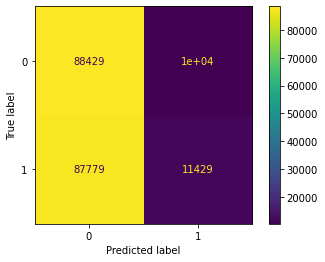

In [ ]:
# the confusion matrix shows that the baseline model performed pretty poorly. The accuracy of 0.5043 confirms that.
plot_confusion_matrix(gnb, X_test_svd, y_test);

In [ ]:
# the accuracy score
gnb.score(X_test_svd, y_test)

0.5043333333333333

# Prediction Models
 I decided to try several classification models to see which one would perform better.
 These are the ones that I tried:
 Logistic Regression,
 Decision Tree Classifier,
 Rendom Forest Classifier, and 
 Neural Networks

## Logistic Regression


0.511550505050505


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


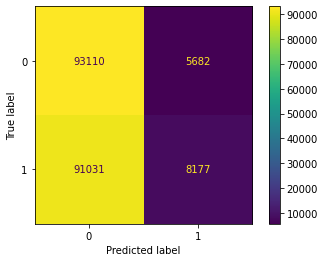

In [ ]:
# instantiate the logistic regression model
lrg = LogisticRegression()
# fit the training set into the model
lrg.fit(X_train_svd, y_train)
# print the accuracy score
print(lrg.score(X_test_svd, y_test))
# see the confusion matrix
plot_confusion_matrix(lrg, X_test_svd, y_test);

## Decision Tree Classifier

In [ ]:
# instantiate the decision tree model 
dec_tree = DecisionTreeClassifier(random_state = 42)
# fit the training set into the model
dec_tree.fit(X_train_svd, y_train)
# print out the accuracy score
dec_tree.score(X_test_svd, y_test)

0.5134343434343435

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


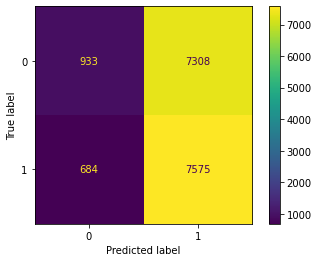

In [ ]:
# see the confusion matrix
plot_confusion_matrix(dec_tree, X_test_svd, y_test);

## Random Forest Classifier

In [18]:
# create an instance of Random Forest Classifier
random_forest = RandomForestClassifier(random_state = 42)

In [22]:
# fit the training set into the model
random_forest.fit(X_train_svd,y_train)

RandomForestClassifier(random_state=42)

In [23]:
# print out the accuracy score
random_forest.score(X_test_svd, y_test)

0.5142020202020202

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


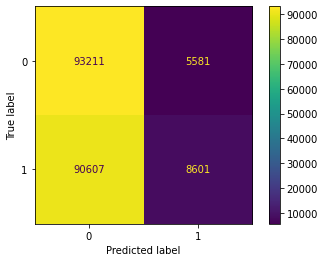

In [25]:
# see the confusion matrix
plot_confusion_matrix(random_forest, X_test_svd, y_test);

# Conclusion after running the models before tuning the hyperparameters:

The accuracy scores that I achieved after running the models were all either equal to or just slightly higher than 50 percent. My next step is to tune the hyperparameters using GridSearch CV and see if that improves the scores. 



## Grid Search on Logistic Regression

In [ ]:
# specifying what hyperparameters and which values of those hyperparameters I want the Grid Search to run on.
grid={"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty":["l2"]}

In [ ]:
# the previously created instance of Logistic Regresion will be used as the estimator in this Grid Search.
logreg_cv=GridSearchCV(estimator = lrg,param_grid = grid,cv=10, verbose = 1)

In [ ]:
# fit the training set into the Grid Search instance. 
logreg_cv.fit(X_train_svd,y_train)

Fitting 10 folds for each of 7 candidates, totalling 70 fits


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l2']},
             verbose=1)

In [ ]:
print("tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hyperparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2'}
accuracy : 0.5130746268656716


## Results of tuning the hyperparameters for Logistic Regression:
Unofortunately the model's performance improved to a very insignificant degree ( by only 0.15 percent).


## Grid Search on Decision Tree


In [ ]:
%time
dec_tree = DecisionTreeClassifier(random_state = 42)
dec_tree.fit(X_train_svd, y_train)
dec_tree.score(X_test_svd, y_test)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs


0.5156363636363637

In [ ]:
grid = {
    'max_depth': [2,3,5,6,7,8],
    'min_samples_leaf': [2,4,6,8,10]
}

In [ ]:
dec_tree_cv = GridSearchCV(estimator = dec_tree, 
                            param_grid = grid, 
                            cv = 4, verbose = 1, scoring = "f1")

In [ ]:
dec_tree_cv.fit(X_train_svd,y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [2, 3, 5, 6, 7, 8],
                         'min_samples_leaf': [2, 4, 6, 8, 10]},
             scoring='f1', verbose=1)

In [ ]:
print("tuned hyperparameters :(best parameters) ",dec_tree_cv.best_params_)
print("accuracy :",dec_tree_cv.best_score_)

tuned hyperparameters :(best parameters)  {'max_depth': 7, 'min_samples_leaf': 4}
accuracy : 0.5309807998855914


In [ ]:
type(dec_tree_cv)

sklearn.model_selection._search.GridSearchCV

## Grid Search on Random Forest

In [19]:
grid = {
 'max_depth': [1,2,3,5,7,9],
 'max_features': ['sqrt','log2'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}

In [20]:
random_forest_cv = GridSearchCV(estimator = random_forest, param_grid = grid, cv = 4,verbose = 1)

In [ ]:
random_forest_cv.fit(X_train_svd,y_train)

Fitting 4 folds for each of 540 candidates, totalling 2160 fits


In [ ]:
print("tuned hyperparameters :(best parameters) ",random_forest_cv.best_params_)
print("accuracy :",random_forest_cv.best_score_)

## Neural Networks First Simple Model

In [ ]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=300, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# fit the keras model on the dataset
model.fit(X_train_svd, y_train, epochs=150, batch_size=10)

Epoch 1/150
40200/40200 [==============================] - 101s 2ms/step - loss: 0.6928 - accuracy: 0.5014
Epoch 2/150
40200/40200 [==============================] - 99s 2ms/step - loss: 0.6921 - accuracy: 0.5030
Epoch 3/150
40200/40200 [==============================] - 99s 2ms/step - loss: 0.6918 - accuracy: 0.5036
Epoch 4/150
40200/40200 [==============================] - 98s 2ms/step - loss: 0.6916 - accuracy: 0.5053
Epoch 5/150
40200/40200 [==============================] - 98s 2ms/step - loss: 0.6915 - accuracy: 0.5041
Epoch 6/150
40200/40200 [==============================] - 98s 2ms/step - loss: 0.6913 - accuracy: 0.5055
Epoch 7/150
40200/40200 [==============================] - 97s 2ms/step - loss: 0.6912 - accuracy: 0.5062
Epoch 8/150
40200/40200 [==============================] - 97s 2ms/step - loss: 0.6910 - accuracy: 0.5076
Epoch 9/150
40200/40200 [==============================] - 97s 2ms/step - loss: 0.6910 - accuracy: 0.5069
Epoch 10/150
40200/40200 [===================

In [ ]:
# evaluate the keras model
_, accuracy = model.evaluate(X, y)
print('Accuracy: %.2f' % (accuracy*100))

In [ ]:
# make class predictions with the model
predictions = (model.predict(X_test_svd) > 0.5).astype(int)

In [ ]:
# summarize the first 5 cases
for i in range(5):
	print('%s => %d (expected %d)' % (X[i].tolist(), predictions[i], y[i]))

# Unsupervised Learning. KMeans Clustering and Hierarchical Clustering. 
I wanted to check if the reaason why the models performed so poorly was because the target labels were not accurate. I figured that a good way to check would be to recreate my own labels using unsupervised learning models and rerun the models using those new labels and see if the performance improved. I used KMeans Clustering and Hierarchical clustering for creating new labels. With each model I tried creating first two then several clusters to see if the actual number of categories in the dataset was more than two. 

## KMEANS Clustering

In [16]:
# instantiate a KMEANS object with two clusters.
kmeans = KMeans(n_clusters = 2, init = 'k-means++',n_init = 100, random_state = 42).fit(X_train_svd)

In [19]:
# check for optimal number of clusters
Sum_of_squared_distances = []
K = range(1,8)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(X_train_svd)
    Sum_of_squared_distances.append(km.inertia_)

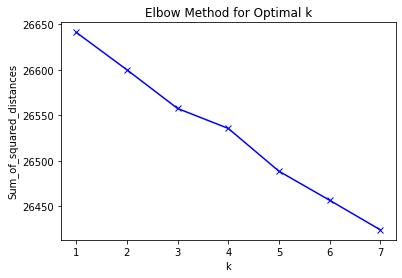

In [20]:
# visualize what number of clusters has the lowest sum of squared distances. 
plt.plot(K,Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method for Optimal k')
plt.show()


In [17]:
# assign the newly created labels for the testing set into the variable test_data_predictions
test_data_predictions = kmeans.predict(X_test_svd)

In [18]:
# assign the newly created labels for the training set into the variable train_data_predictions
train_data_predictions = kmeans.predict(X_train_svd)

In [21]:
len(test_data_predictions)

198000

In [20]:
# check the breakdown of the target labels for the testing set.
# we can see that almost all of the labels were predicted to be label 1. That means that 
np.unique(test_data_predictions,return_counts = True)

(array([0, 1], dtype=int32), array([    11, 197989]))

In [36]:
print("length of test data predictions: ", len(test_data_predictions))
print("length of y_test: ",len(y_test))

length of test data predictions:  198000
length of y_test:  198000


# Decision Tree Classifier with the new target variable.
I wanted to see if running the decision tree model with the newly created target labels was going to improve the accuracy score.  


In [46]:
# create a new target variable for the testing set out of the labels created by clustering.
y_cluster_test = test_data_predictions.tolist()

In [45]:
# create a new target variable for the training set out of the labels created by clustering. 
y_cluster_train = train_data_predictions.tolist()

In [49]:
# create a new instance of the Decision Tree Classifier and fit the training set on it.
dec_tree = DecisionTreeClassifier(random_state = 42)
dec_tree.fit(X_train_svd, y_cluster_train)


DecisionTreeClassifier(random_state=42)

In [50]:
# the accuracy score with the testing set.
dec_tree.score(X_test_svd, y_cluster_test)

1.0

# Hierarchical Clustering
I wanted to see how hierarchical clustering was going to perform so I tried running it on 600 000 comments and the kernel kept collapsing even with 25 GB of RAM that Google COlab Pro provides. So I decided to run it on a subsample of the original dataset. I created a new dataframe with 50 000 comments and ran the Hierarchical Clustering on it. I performed a new vectorization, train-test split and dimensionality reduction on this new sample of the dataset.

In [22]:
# create a subsample of the original dataset.
df_sample = df.sample(n = 50000)
print(len(df_sample))
# assign the predictor variable out of the column with the clean text.
X = df_sample['low_removed']

# assign the target variable
y = df_sample['target']

50000


Vectorization and train-test split.

In [23]:
# instantiate the vectorizer with the parameters that we need. 
# I adjusted the max_df and min_df parameters several times before and found that the current combination produces the 
# highest possible accuracy score. 
vectorizer = TfidfVectorizer(max_df = 60, min_df = 40)

In [24]:
# fit and transform the predictor column with the vectorizer.
X_vect = vectorizer.fit_transform(X.values.astype(str))

In [25]:
# perform the train_test split. 
X_train, X_test, y_train, y_test = train_test_split(X_vect,y,test_size=0.33, random_state=42) 

In [26]:
# the number of columns of the dataset after the vectorization is 342.
X_train.shape

(33500, 342)

Dimensionality Reduction with TruncatedSVD.

In [27]:
# Since the new dataset has only 342 columns, I am going to tell the TruncatedSVD to reduce the dimensions
# of the dataset to 150 features. 
# instantiate the TruncatedSVD with 150 components. 
svd = TruncatedSVD(n_components= 150, random_state=42)
svd.fit(X_train)

TruncatedSVD(n_components=150, random_state=42)

In [28]:
# The dimensionality reduction of the X_train produces a numpy ndarray with 150 features
# and I am assigning it to X_train_svd_sample. 
X_train_svd_sample = svd.transform(X_train)

In [29]:
# The features of X_test also get reduced to 150 and the new numpy ndarray gets assigned to X_test_svd_sample
X_test_svd_sample = svd.transform(X_test)

In [30]:
# see how much of the variance in the dataset got captured after dimensionality reduction.
sum(svd.explained_variance_ratio_)

0.4986610161460776

In [31]:
X_train_svd_sample.shape

(33500, 150)

In [32]:
# X_train_svd needs to be first converted to a list and then into an array again so that it is no longer a sparse matrix.
# the reason I am doing that is because some of the models do not accept sparse matrices.
X_train_svd_sample = X_train_svd_sample.tolist()
print(type(X_train_svd_sample))
X_train_svd_sample = np.asarray(X_train_svd_sample)

<class 'list'>


After the vectorization, train-test split and dimensionality reduction are done, I run the Hierarchical clustering.

In [36]:
# instantiate the clustering algorithm.
hier_clustering = AgglomerativeClustering().fit(X_train_svd_sample)
# fit the training set into the model, predict the clusters and assign the results to a new variable.
predict_targets_hierarchical = hier_clustering.fit_predict(X_train_svd_sample)
# see what is the breakdown of the predicted clusters. 
np.unique(predict_targets_hierarchical,return_counts = True)


(array([0, 1]), array([33460,    40]))

The clustering predicted that almost all of the comments have a label 0.

# Results from Clustering
Both clustering algorithms show that the overwhelming majority of observations are supposed to be class 0. That means that the dataset could be imbalanced. 



# Evaluation
I have several possible explanations as to why the accuracy scores of the models were so low. The first possibility is that the dataset was not labeled properly. The second possible explanation is that even after all the preprocessing steps taken, there is still some noise left in the dataset that needs to be detected and removed before running the models again. Another possible explanation is that the vectorizer that I used did not pick up the most important words properly. I am hoping that trying new vectorizers such as HashingVectorizer or CountVectorizer could help.